In [18]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import astropy.units as u

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 24,
    'axes.labelsize': 'large',
    'mathtext.fontset': 'stix'
})

In [2]:
with fits.open('/data2/lsajkov/mpdg/data/DESI/edr_galaxy_stellarmass_lineinfo_v1.0.fits') as edr_cat:
    edr_cat = Table(edr_cat[1].data)

In [ ]:
flux_r = edr_cat['FLUX_R']
r_snr  = edr_cat['FLUX_R'] * np.sqrt(edr_cat['FLUX_IVAR_R'])

flux_g = edr_cat['FLUX_G']
g_snr  = edr_cat['FLUX_G'] * np.sqrt(edr_cat['FLUX_IVAR_G'])

flux_z = edr_cat['FLUX_Z']
z_snr  = edr_cat['FLUX_Z'] * np.sqrt(edr_cat['FLUX_IVAR_Z'])

r_mag     = 22.5 - 2.5 * np.log10(edr_cat['FLUX_R']) #original in nanomaggys
r_mag_err = 2.5 / (edr_cat['FLUX_R'] * np.sqrt(edr_cat['FLUX_IVAR_R']))

g_mag     = 22.5 - 2.5 * np.log10(edr_cat['FLUX_G']) #original in nanomaggys
g_mag_err = 2.5 / (edr_cat['FLUX_G'] * np.sqrt(edr_cat['FLUX_IVAR_G']))

z_mag     = 22.5 - 2.5 * np.log10(edr_cat['FLUX_Z']) #original in nanomaggys
z_mag_err = 2.5 / (edr_cat['FLUX_Z'] * np.sqrt(edr_cat['FLUX_IVAR_Z']))

gr_color = g_mag - r_mag
gr_color_err = np.sqrt(g_mag_err ** 2 + r_mag_err ** 2)

gz_color = g_mag - z_mag
gr_color_err = np.sqrt(g_mag_err ** 2 + z_mag_err ** 2)

rz_color = r_mag - z_mag
rz_color_err = np.sqrt(r_mag_err ** 2 + z_mag_err ** 2)

log_mstar     = np.log10(edr_cat['SED_MASS']) #original in solar masses
log_mstar_err = edr_cat['SED_MASSERR']/(edr_cat['SED_MASS'] * np.log(10))

redshift = edr_cat['Z']

Text(0, 0.5, 'Count')

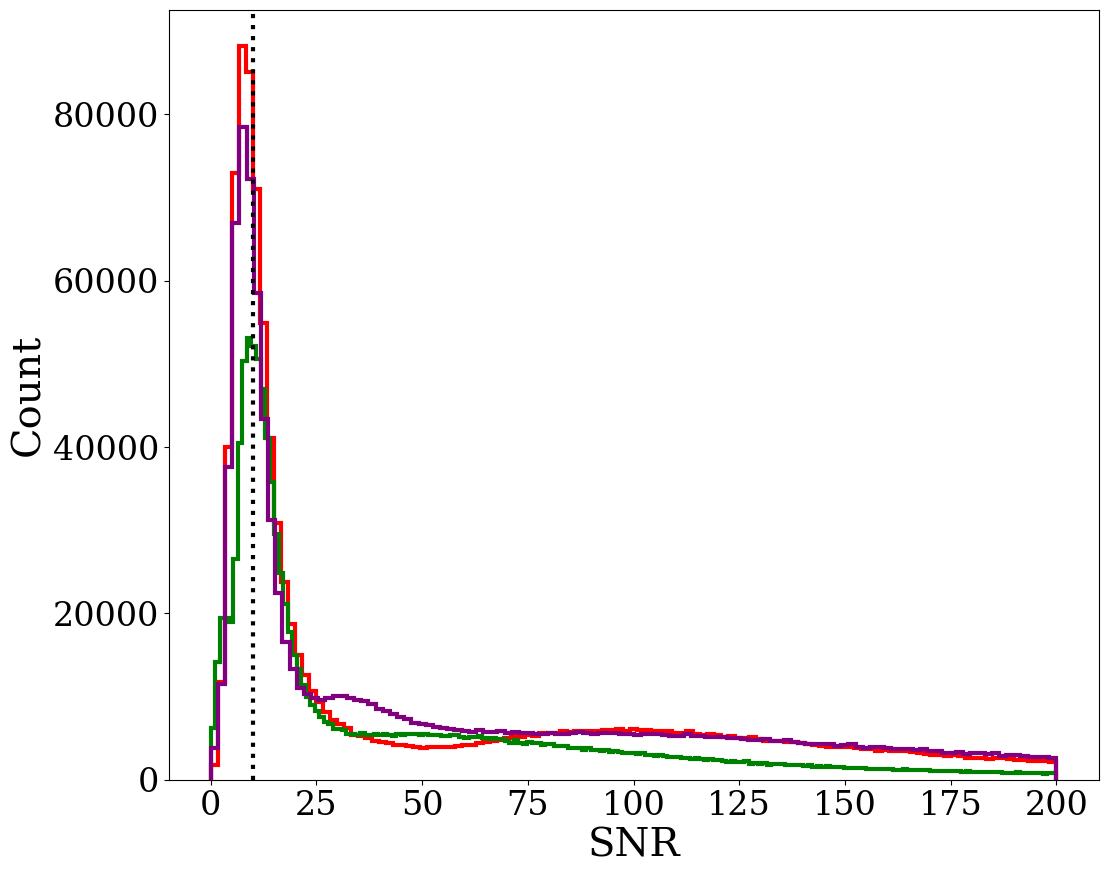

In [37]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(r_snr[(r_snr < 200) & (r_snr > 0)],
        bins = 'auto', histtype = 'step', color = 'red', linewidth = 3)
ax.hist(g_snr[(g_snr < 200) & (g_snr > 0)],
        bins = 'auto', histtype = 'step', color = 'green', linewidth = 3)
ax.hist(z_snr[(z_snr < 200) & (z_snr > 0)],
        bins = 'auto', histtype = 'step', color = 'purple', linewidth = 3)

ax.axvline(10, color = 'black', linestyle = ':', linewidth = 3)

ax.set_xlabel('SNR')
ax.set_ylabel('Count')

In [52]:
#quality cuts
snr_thresh = 10
snr_cut = (r_snr >= snr_thresh) &\
          (g_snr >= snr_thresh) &\
          (z_snr >= snr_thresh)

redshift_cut = (redshift >= 0) & (redshift < 10)

color_lo = -3
color_hi = 3
color_cut = (gr_color > color_lo) & (gr_color < color_hi) &\
            (gz_color > color_lo) & (gz_color < color_hi) &\
            (rz_color > color_lo) & (rz_color < color_hi)

log_mstar_lo = 6
log_mstar_hi = 12
log_mstar_cut = (log_mstar > log_mstar_lo) & (log_mstar < log_mstar_hi)

morphtype_cut = edr_cat['MORPHTYPE'] != 'PSF'

In [72]:
#define primary targeting region
def gr_color_condition(gr_color, gr_color_err,
               r_mag):
    
    return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9

def rz_color_condition(rz_color, r_mag):

    return (rz_color + 0.25 * r_mag) < 5.85

In [73]:
prt_gr_color_cut = gr_color_condition(gr_color,
                                      gr_color_err,
                                      r_mag)

prt_rz_color_cut = rz_color_condition(rz_color,
                                      r_mag)

prt_mag_cut = r_mag > 18

/var/tmp/lsajkov/ipykernel_3971127/3526100393.py:5: RuntimeWarning: invalid value encountered in subtract
  return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9
/var/tmp/lsajkov/ipykernel_3971127/3526100393.py:5: RuntimeWarning: invalid value encountered in add
  return (gr_color - gr_color_err + 0.06 * (r_mag - 14)) < 0.9


In [74]:
total_cut = snr_cut &\
            redshift_cut &\
            color_cut &\
            log_mstar_cut &\
            morphtype_cut &\
            prt_gr_color_cut &\
            prt_rz_color_cut &\
            prt_mag_cut

print('Grand total of cuts:')
print(f'{np.sum(total_cut)}/{len(total_cut)} (~{int(100 * np.sum(total_cut)/len(total_cut))}%)')

Grand total of cuts:
71068/1223269 (~5%)


Text(0, 0.5, 'Count')

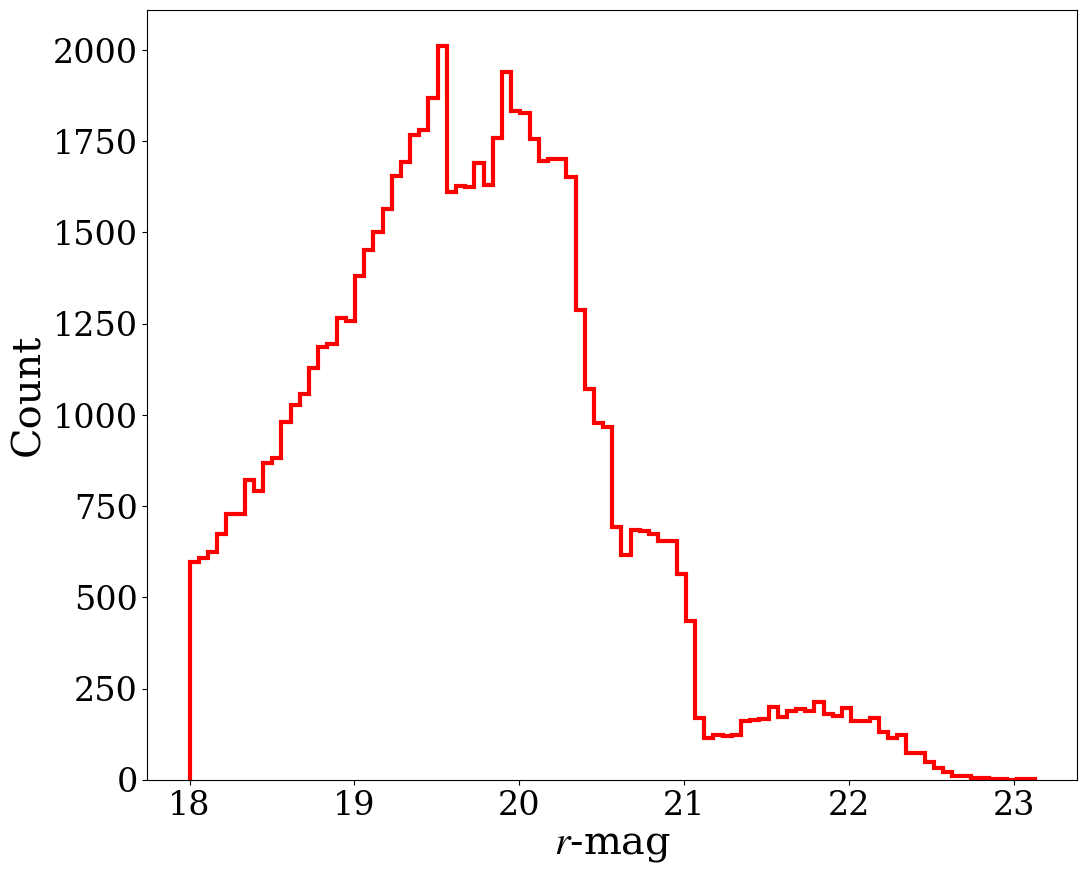

In [75]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(r_mag[total_cut],
        bins = 'auto', histtype = 'step', color = 'red', linewidth = 3)

# ax.hist(g_mag[total_cut],
#         bins = 'auto', histtype = 'step', color = 'green', linewidth = 3)

# ax.hist(z_mag[total_cut],
#         bins = 'auto', histtype = 'step', color = 'purple', linewidth = 3)

ax.set_xlabel('$r$-mag')
ax.set_ylabel('Count')

(array([1.620e+02, 1.080e+02, 1.720e+02, 3.010e+02, 5.490e+02, 7.590e+02,
        9.560e+02, 8.920e+02, 7.800e+02, 7.960e+02, 8.970e+02, 1.259e+03,
        1.138e+03, 1.392e+03, 1.536e+03, 1.380e+03, 1.630e+03, 2.000e+03,
        2.077e+03, 2.177e+03, 1.597e+03, 1.620e+03, 1.716e+03, 1.671e+03,
        1.797e+03, 1.553e+03, 1.795e+03, 1.794e+03, 2.237e+03, 2.098e+03,
        2.220e+03, 2.276e+03, 1.790e+03, 1.487e+03, 1.423e+03, 1.131e+03,
        1.248e+03, 1.268e+03, 1.295e+03, 1.125e+03, 1.022e+03, 1.193e+03,
        1.016e+03, 9.200e+02, 8.080e+02, 7.630e+02, 7.260e+02, 5.040e+02,
        5.410e+02, 4.980e+02, 5.890e+02, 4.970e+02, 4.240e+02, 4.280e+02,
        3.630e+02, 2.970e+02, 2.760e+02, 2.890e+02, 2.800e+02, 2.850e+02,
        2.650e+02, 2.110e+02, 1.800e+02, 1.520e+02, 1.520e+02, 1.340e+02,
        1.220e+02, 8.900e+01, 7.400e+01, 8.000e+01, 6.200e+01, 5.600e+01,
        4.300e+01, 4.900e+01, 5.300e+01, 4.200e+01, 4.800e+01, 2.200e+01,
        3.400e+01, 1.600e+01, 2.400e+0

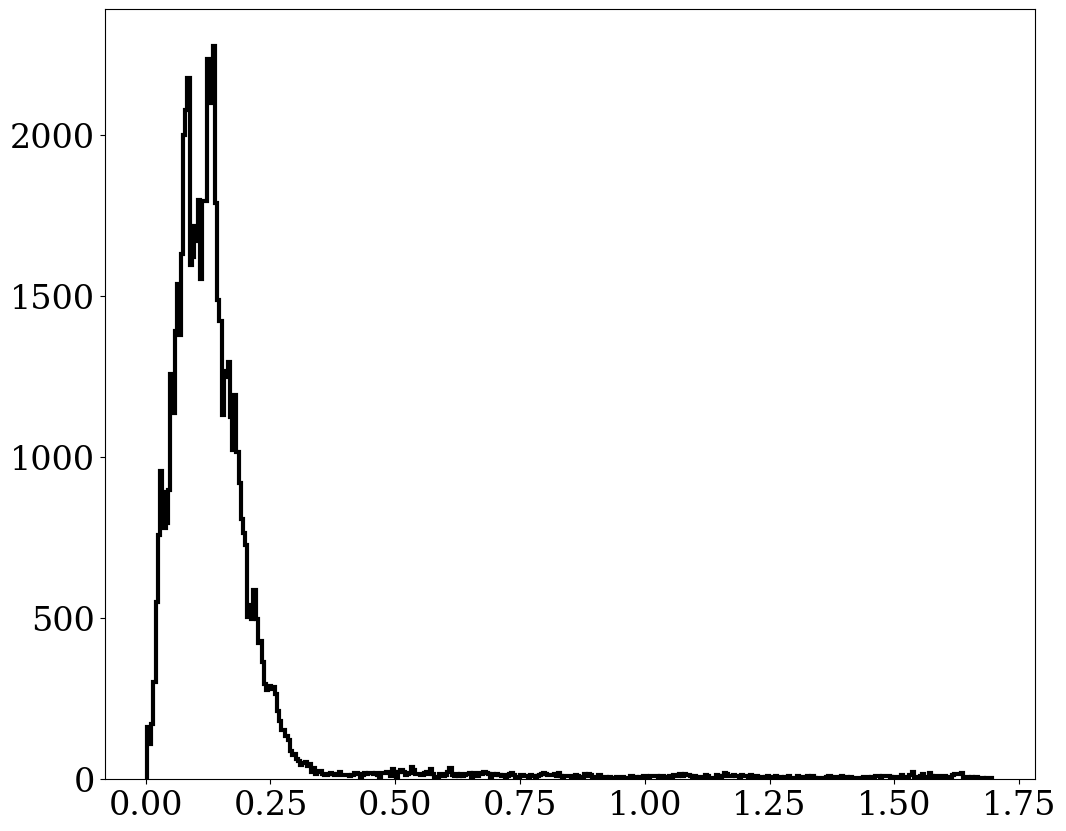

In [76]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(redshift[total_cut],
        bins = 'auto', histtype = 'step', color = 'black', linewidth = 3)

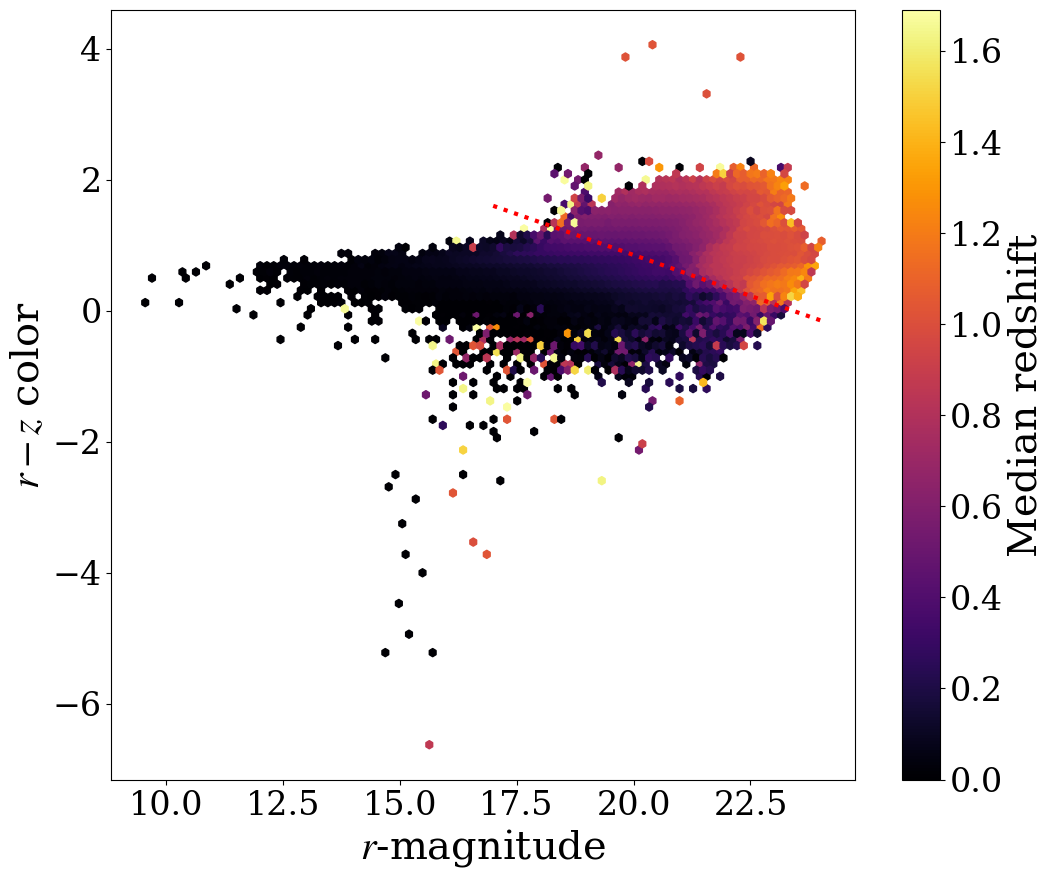

In [83]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

hxb = ax.hexbin(r_mag[snr_cut],
          rz_color[snr_cut], C = redshift[snr_cut],
          reduce_C_function = np.median,
          cmap = 'inferno')

fig.colorbar(mappable = hxb,
             label = 'Median redshift')

ax.set_xlabel('$r$-magnitude')
ax.set_ylabel('$r-z$ color')

ax.plot(np.array([17, 24]),
        5.85 - 0.25 * np.array([17, 24]), color = 'red',
        linestyle = ':', linewidth = 3)

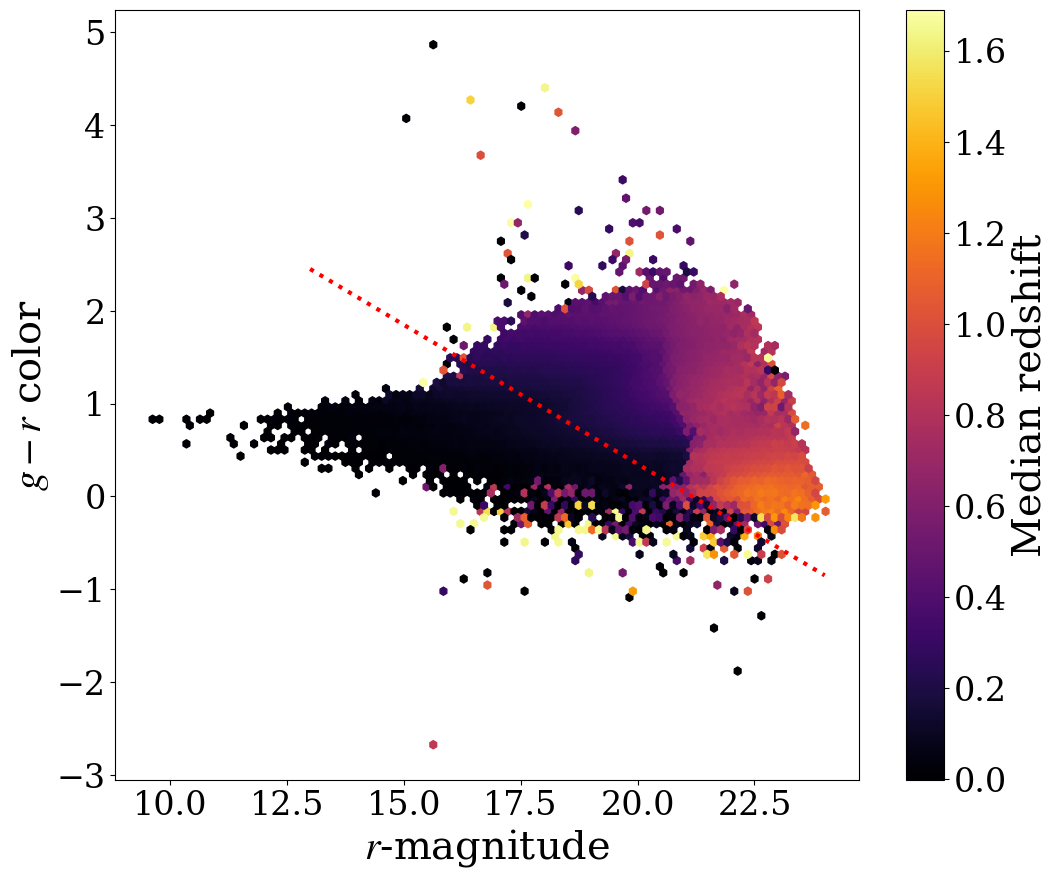

In [95]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

hxb = ax.hexbin(r_mag[snr_cut],
          gr_color[snr_cut], C = redshift[snr_cut],
          reduce_C_function = np.median,
          cmap = 'inferno')

fig.colorbar(mappable = hxb,
             label = 'Median redshift')

ax.set_xlabel('$r$-magnitude')
ax.set_ylabel('$g-r$ color')

ax.plot(np.array([13, 24]),
        6.35 - 0.30 * np.array([13, 24]), color = 'red',
        linestyle = ':', linewidth = 3)

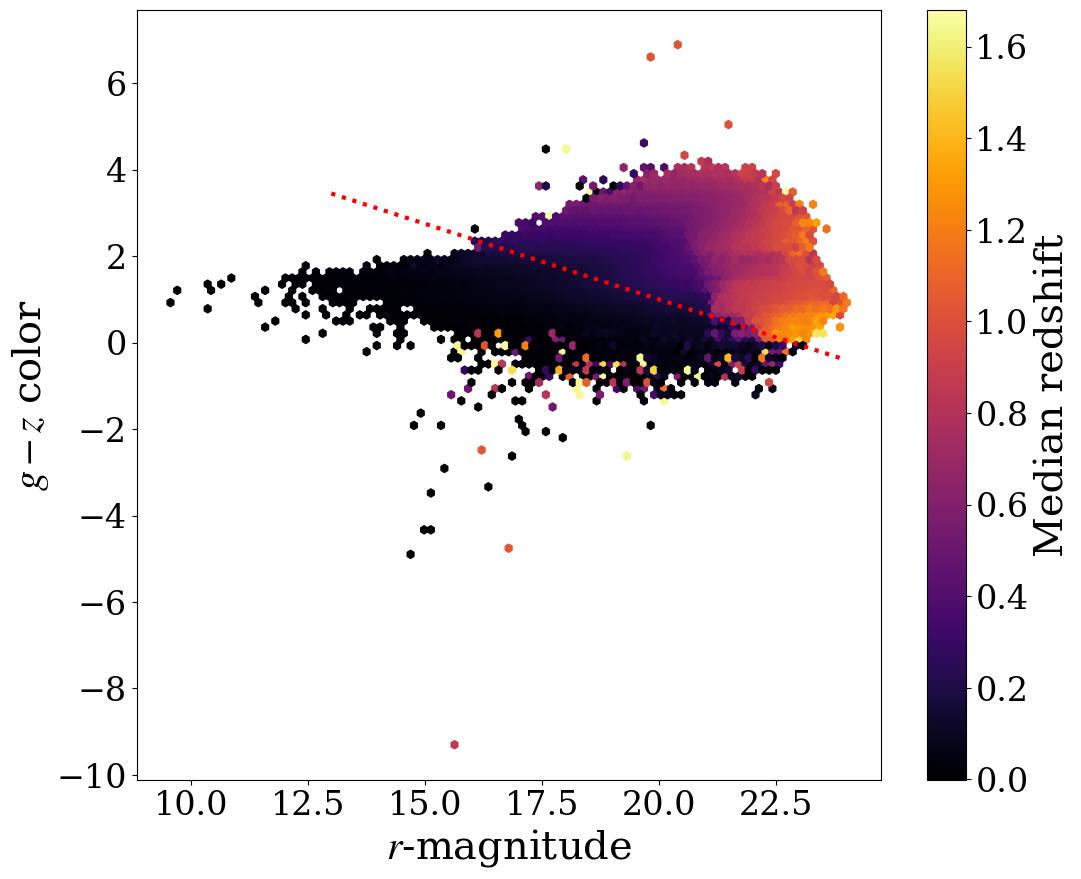

In [100]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

hxb = ax.hexbin(r_mag[snr_cut],
          gz_color[snr_cut], C = redshift[snr_cut],
          reduce_C_function = np.median,
          cmap = 'inferno')

fig.colorbar(mappable = hxb,
             label = 'Median redshift')

ax.set_xlabel('$r$-magnitude')
ax.set_ylabel('$g-z$ color')

ax.plot(np.array([13, 24]),
        8 - 0.35 * np.array([13, 24]), color = 'red',
        linestyle = ':', linewidth = 3)

(array([8.000e+00, 8.000e+00, 7.000e+00, 1.000e+01, 8.000e+00, 6.000e+00,
        1.000e+01, 1.900e+01, 1.300e+01, 1.300e+01, 1.400e+01, 1.200e+01,
        2.200e+01, 1.400e+01, 2.100e+01, 2.200e+01, 1.600e+01, 3.100e+01,
        2.400e+01, 2.200e+01, 1.800e+01, 2.900e+01, 2.200e+01, 2.500e+01,
        2.900e+01, 3.300e+01, 3.900e+01, 3.800e+01, 3.000e+01, 4.200e+01,
        5.000e+01, 5.900e+01, 5.800e+01, 5.200e+01, 5.700e+01, 7.500e+01,
        8.200e+01, 8.600e+01, 9.800e+01, 9.900e+01, 1.060e+02, 1.000e+02,
        1.160e+02, 1.410e+02, 1.630e+02, 1.790e+02, 1.700e+02, 1.940e+02,
        1.940e+02, 2.010e+02, 2.280e+02, 2.400e+02, 2.640e+02, 2.890e+02,
        3.070e+02, 3.520e+02, 3.380e+02, 3.720e+02, 3.990e+02, 3.980e+02,
        4.230e+02, 4.490e+02, 4.860e+02, 5.320e+02, 5.310e+02, 5.530e+02,
        5.960e+02, 6.510e+02, 6.690e+02, 7.310e+02, 7.560e+02, 9.040e+02,
        8.800e+02, 9.610e+02, 9.640e+02, 1.054e+03, 1.102e+03, 1.189e+03,
        1.260e+03, 1.326e+03, 1.374e+0

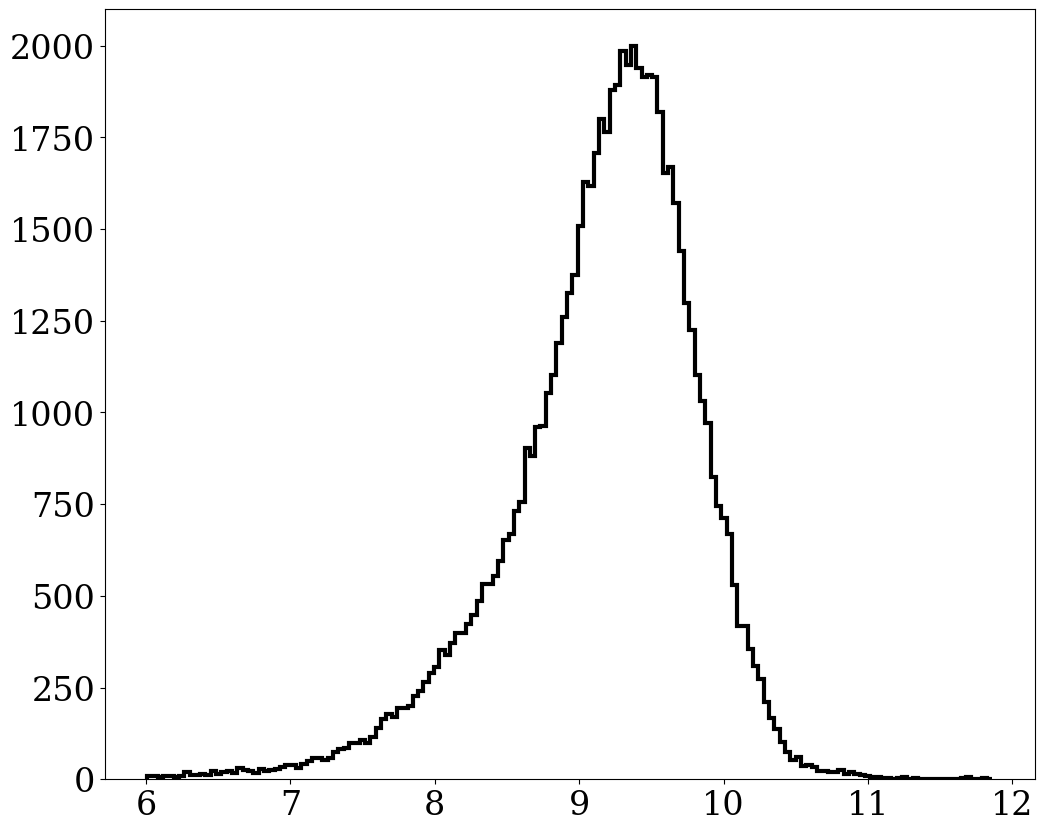

In [77]:
fig = plt.figure(figsize = (12, 10))
ax = fig.add_subplot()

ax.hist(log_mstar[total_cut],
        bins = 'auto', histtype = 'step', color = 'black', linewidth = 3)

In [ ]:
plot_cut = snr_cut &\
           redshift_cut &\
           color_cut &\
           log_mstar_cut &\
           morphtype_cut &\
           prt_gr_color_cut &\

In [ ]:
edr_cat['FLUX_G']